# Simulation-based inference with the Python package `sbijax`

In [7]:
import arviz as az
import jax
import haiku as hk
%matplotlib inline
import matplotlib.pyplot as plt
import optax
import seaborn as sns
import tueplots.bundles
import tueplots.axes

from functools import partial
from jax import numpy as jnp
from jax import random as jr

from sbijax import CMPE, NRE, NPE, FMPE, NLE
from sbijax.nn import ConsistencyModel, CCNF, make_mdn
from sbijax.mcmc import sample_with_nuts, as_inference_data

from tensorflow_probability.substrates.jax import distributions as tfd

In [2]:
custom_params = {
    'font.family':'serif', 
    'font.weight':'ultralight', 
    'font.serif':'Computer Modern',
    "axes.labelweight": "light",
    "mathtext.fontset": "stix",
    'text.usetex': True,
}
sns.set_theme(style="ticks", context='paper', rc=custom_params)
plt.rcParams.update(tueplots.bundles.icml2022())
plt.rcParams.update(tueplots.axes.lines(base_width=0.5))

In [11]:
def plot(inference_data):
    _, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
    colors = sns.blend_palette(["#636363", "#b26679"], n_colors=2)
    with az.style.context(["arviz-white"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"
        axes = az.plot_posterior(
            inference_data,
            color=colors[1],
            kind='hist',
            hdi_prob=0.9,
            edgecolor='black',
            ax=axes
        )
        for ax in axes.flatten():
            ax.spines[['right', 'top']].set_visible(False)
            ax.spines.left.set_linewidth(.5)
            ax.spines.bottom.set_linewidth(.5)
            ax.xaxis.set_tick_params(width=0.5, length=2)
            ax.yaxis.set_tick_params(width=0.5, length=2)
            ax.grid(which='major', axis='both', alpha=0.25)            
            ax.set_title(None)
        plt.tight_layout()
    return axes

## Generative model

In [4]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Normal(jnp.zeros(2), 1)
    ), batch_ndims=0)
    return prior


def simulator_fn(seed, theta):
    mean = theta["theta"].reshape(-1, 2)
    n = mean.shape[0]
    data_key, cat_key = jr.split(seed)
    categories = tfd.Categorical(logits=jnp.zeros(2)).sample(seed=cat_key, sample_shape=(n,))
    scales = jnp.array([1.0, 0.1])[categories].reshape(-1, 1)
    y = tfd.Normal(mean, scales).sample(seed=data_key)
    return y

## Observation

In [5]:
y_observed = jnp.array([-1.0, 1.0])

## NUTS 

In [67]:
def likelihood_fn(y, theta):
    mean = theta["theta"].reshape(1, 2)
    mix = tfd.Categorical(logits=jnp.zeros(2))
    likelihood = tfd.MixtureSameFamily(
        mixture_distribution=mix,
        components_distribution=tfd.MultivariateNormalDiag(
            jnp.concatenate([mean, mean], axis=0),
            jnp.concatenate([jnp.full((1, 2), 1.0), jnp.full((1, 2), 0.01)], axis=0),
        )
    )
    ll = likelihood.log_prob(y)
    return ll

In [68]:
def log_density_fn(theta, y):
    prior_lp = prior_fn().log_prob(theta)
    likelihood_lp = likelihood_fn(y, theta)
    lp = jnp.sum(prior_lp) + jnp.sum(likelihood_lp)
    return lp

In [69]:
prior_fn().sample(seed=jr.PRNGKey(2))

{'theta': Array([0.40356722, 1.3396233 ], dtype=float32)}

In [95]:
log_density_partial = partial(log_density_fn, y=y_observed)
samples = sample_with_nuts(
    jr.PRNGKey(0),
    log_density_partial,
    prior_fn().sample
)
inference_results = as_inference_data(samples, jnp.squeeze(y_observed))

In [99]:
az.ess(inference_results, relative=True)

<xarray.Dataset> Size: 32B
Dimensions:    (theta_dim: 2)
Coordinates:
  * theta_dim  (theta_dim) int64 16B 0 1
Data variables:
    theta      (theta_dim) float64 16B 1.074 1.089

In [101]:
az.rhat(inference_results)

<xarray.Dataset> Size: 32B
Dimensions:    (theta_dim: 2)
Coordinates:
  * theta_dim  (theta_dim) int64 16B 0 1
Data variables:
    theta      (theta_dim) float64 16B 1.002 1.003

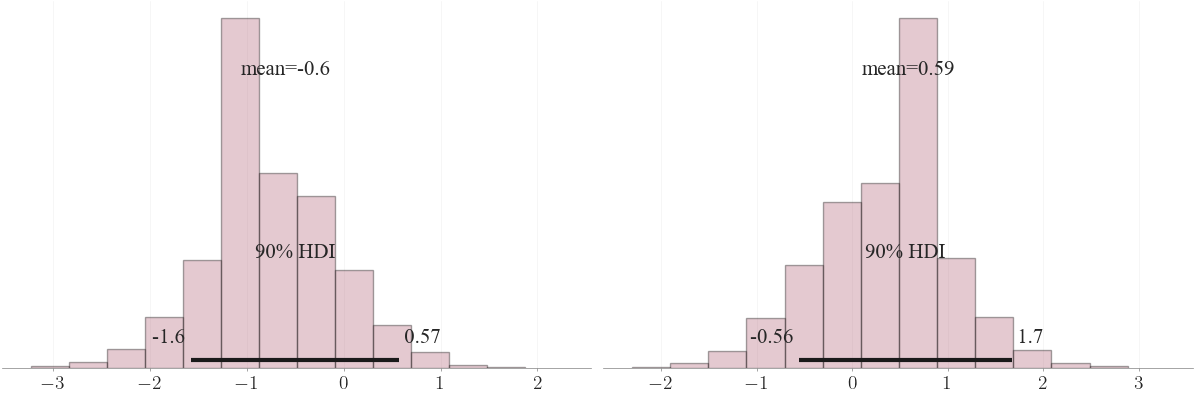

In [102]:
plot(inference_results)
plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/appendix-mixture_model-nuts.pdf")
plt.show()

## CMPE

In [103]:
def make_model(dim):
    @hk.transform
    def _mlp(method, **kwargs):
        def _c_skip(time):
            return 1 / ((time - 0.001) ** 2 + 1)

        def _c_out(time):
            return 1.0 * (time - 0.001) / jnp.sqrt(1 + time**2)

        def _nn(theta, time, context, **kwargs):
            ins = jnp.concatenate([theta, time, context], axis=-1)
            outs = hk.nets.MLP([64, 64, dim])(ins)
            out_skip = _c_skip(time) * theta + _c_out(time) * outs
            return out_skip

        cm = ConsistencyModel(dim, _nn)
        return cm(method, **kwargs)

    return _mlp

In [104]:
fns = prior_fn, simulator_fn
model = CMPE(fns, make_model(2))

data, _ = model.simulate_data(jr.PRNGKey(1), n_simulations=10_000)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    optimizer=optax.adam(1e-3),
    n_early_stopping_patience=25
)

 12%|████████████████▊                                                                                                                         | 122/1000 [00:37<04:30,  3.25it/s]


In [105]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

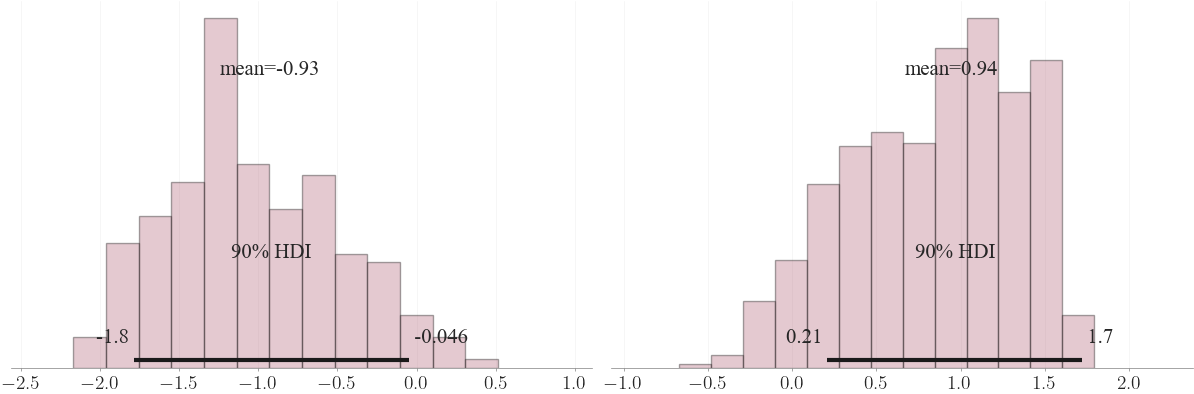

In [106]:
plot(inference_results)
plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/appendix-mixture_model-cmpe.pdf")
plt.show()

## NRE

In [107]:
def make_model():
    @hk.without_apply_rng
    @hk.transform
    def _mlp(inputs, **kwargs):
        return hk.nets.MLP([64, 64, 1])(inputs)

    return _mlp

In [108]:
fns = prior_fn, simulator_fn
model = NRE(fns, make_model())

data, _ = model.simulate_data(
    jr.PRNGKey(1), n_simulations=10000
)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    optimizer=optax.adam(1e-3),
    n_iter=1000,
    n_early_stopping_patience=25
)

  5%|██████▊                                                                                                                                    | 49/1000 [00:50<16:15,  1.03s/it]


In [109]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

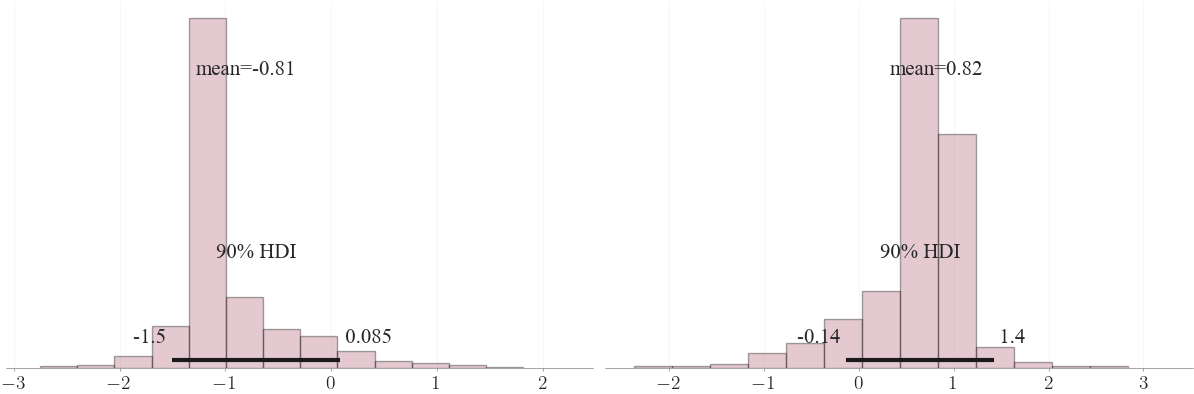

In [110]:
plot(inference_results)
plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/appendix-mixture_model-nre.pdf")
plt.show()

## NPE

In [111]:
import distrax
from surjectors import (
    Chain,
    MaskedAutoregressive,
    Permutation,
    TransformedDistribution,
)
from surjectors.nn import MADE
from surjectors.util import unstack

def make_flow(dim):
    def _bijector_fn(params):
        means, log_scales = unstack(params, -1)
        return distrax.ScalarAffine(means, jnp.exp(log_scales))

    def _flow(method, **kwargs):
        layers = []
        order = jnp.arange(dim)
        for i in range(5):
            layer = MaskedAutoregressive(
                bijector_fn=_bijector_fn,
                conditioner=MADE(
                    dim, [50, dim * 2], 2,
                    w_init=hk.initializers.TruncatedNormal(0.001),
                    b_init=jnp.zeros,                    
                ),
            )
            order = order[::-1]
            layers.append(layer)
            layers.append(Permutation(order, 1))
        chain = Chain(layers)

        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(dim), jnp.ones(dim)),
            1,
        )
        td = TransformedDistribution(base_distribution, chain)
        return td(method, **kwargs)

    td = hk.transform(_flow)
    return td

In [112]:
fns = prior_fn, simulator_fn
model = NPE(fns, make_flow(2))

data, _ = model.simulate_data(
    jr.PRNGKey(1), n_simulations=10000
)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    optimizer=optax.adam(1e-3),
    n_iter=1000,
    n_early_stopping_patience=25
)

 13%|██████████████████▏                                                                                                                       | 132/1000 [00:59<06:31,  2.22it/s]


In [113]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

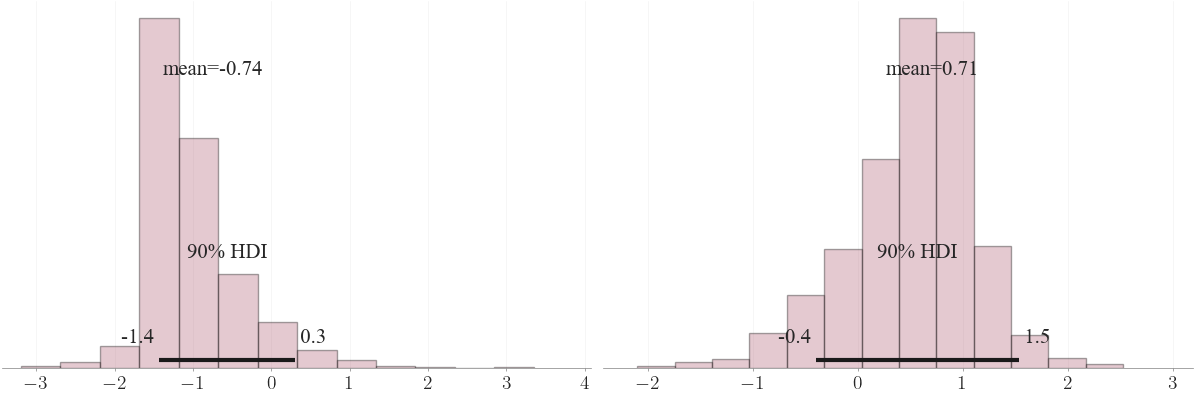

In [114]:
plot(inference_results)
plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/appendix-mixture_model-npe.pdf")
plt.show()

## FMPE

In [118]:
def make_model(dim):
    @hk.transform
    def _mlp(method, **kwargs):
        def _nn(theta, time, context, **kwargs):
            ins = jnp.concatenate([theta, time, context], axis=-1)
            outs = hk.nets.MLP([64, 64, dim])(ins)
            return outs

        ccnf = CCNF(dim, _nn)
        return ccnf(method, **kwargs)

    return _mlp

In [119]:
fns = prior_fn, simulator_fn
model = FMPE(fns, make_model(2))

data, _ = model.simulate_data(
    jr.PRNGKey(1), n_simulations=10000
)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    optimizer=optax.adam(1e-3),
    n_iter=1000,
    n_early_stopping_patience=25
)

  5%|███████▌                                                                                                                                   | 54/1000 [00:11<03:22,  4.66it/s]


In [120]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

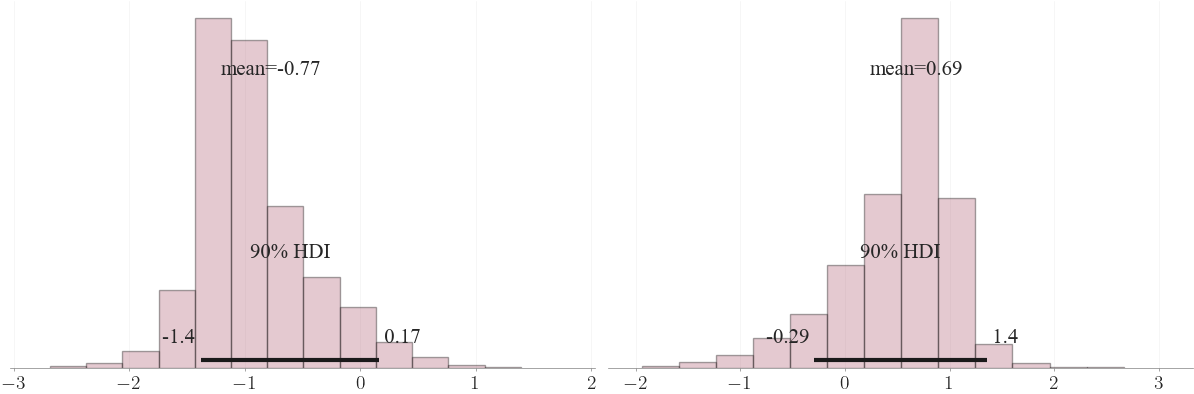

In [121]:
plot(inference_results)
plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/appendix-mixture_model-fmpe.pdf")
plt.show()

## NLE

In [8]:
fns = prior_fn, simulator_fn
model = NLE(fns, make_mdn(2, 10))

data, _ = model.simulate_data(jr.PRNGKey(1))
params, info = model.fit(jr.PRNGKey(2), data=data, n_early_stopping_patience=25, optimizer=optax.adam(1e-3), n_iter=1000)

 11%|███████████████                                                                                                                           | 109/1000 [00:08<01:10, 12.60it/s]


In [9]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

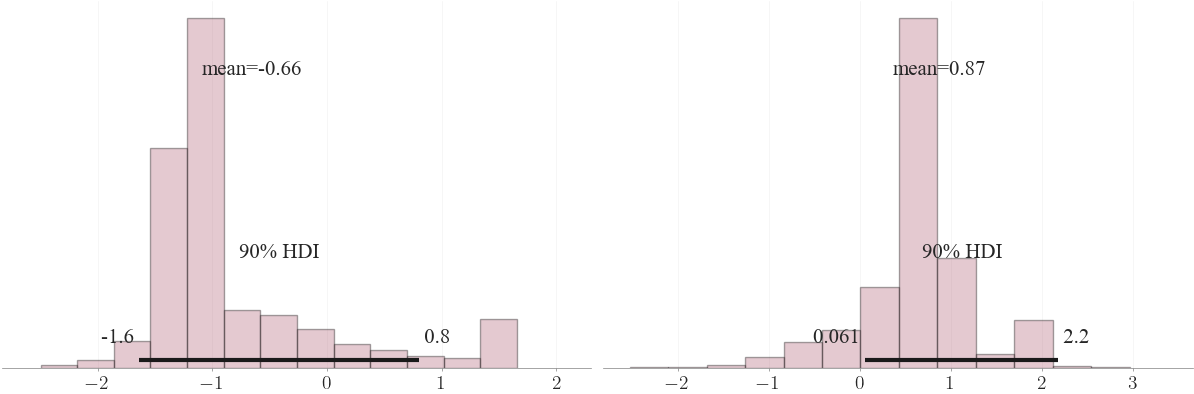

In [14]:
plot(inference_results)
plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/appendix-mixture_model-nle.pdf")
plt.show()